In [ ]:
!pip install timm torchinfo

In [2]:
# Download ICDAR 2003 dataset
# https://drive.google.com/file/d/1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV/view

!gdown 1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
!unzip -q icdar2003.zip -d datasets

Downloading...
From (original): https://drive.google.com/uc?id=1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
From (redirected): https://drive.google.com/uc?id=1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV&confirm=t&uuid=2e08ffc4-26e2-46a5-9b04-d985b9266cee
To: /kaggle/working/icdar2003.zip
100%|███████████████████████████████████████| 45.7M/45.7M [00:00<00:00, 160MB/s]


In [3]:
import os
import xml.etree.ElementTree as ET
import time
import random

import numpy as np
import cv2
from PIL import Image
import timm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

## Extract Data from XML and Store in YOLO format

In [4]:
def extract_data_from_xml(root_dir):
    """Extract data from an XML file containing image metadata, bounding boxes, and labels."""
    xml_path = os.path.join(root_dir, "words.xml")
    tree = ET.parse(xml_path) # Parse XML file
    root = tree.getroot() # Get root element

    img_paths = []
    img_sizes, img_labels = [], []
    bboxes = []

    for img in root: # Iterate through <image> elements
        bbs_of_img, labels_of_img = [], []
        for bbs in img.findall("taggedRectangles"): # Find <taggedRectangles>
            for bb in bbs: # Iterate through <taggedRectangle>
                # Skip if <tag> text is not alphanumeric 
                if not bb[0].text.isalnum():
                    continue
                
                # Skip if <tag> text is contains unwanted characters
                if "é" in bb[0].text.lower() or "ñ" in bb[0].text.lower():
                    continue
                
                # Append bounding box attributes and label
                bbs_of_img.append(
                    [
                        float(bb.attrib["x"]),
                        float(bb.attrib["y"]),
                        float(bb.attrib["width"]),
                        float(bb.attrib["height"])
                    ]
                )
                labels_of_img.append(bb[0].text.lower())

        # Collect image path, size, bounding boxes, and labels
        img_path = os.path.join(root_dir, img[0].text) # Path from <image>
        img_paths.append(img_path)
        img_sizes.append((int(img[1].attrib["x"]), int(img[1].attrib["y"]))) # Size from <size>
        bboxes.append(bbs_of_img)
        img_labels.append(labels_of_img)

    return img_paths, img_sizes, img_labels, bboxes

In [5]:
dataset_dir = "/kaggle/working/datasets/SceneTrialTrain"
image_paths, image_sizes, image_labels, bboxes = extract_data_from_xml(dataset_dir)

print(f"Total images: {len(image_paths)}")
print(f"Total bounding boxes: {sum([len(bbs) for bbs in bboxes])}")
print("=" * 100)
print(f"Example image path: {image_paths[0]}")
print(f"Example image size: {image_sizes[0]}")
print(f"Example bounding boxes: {bboxes[0][:2]}")
print(f"Example labels: {image_labels[0][:2]}")

Total images: 250
Total bounding boxes: 1097
Example image path: /kaggle/working/datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG
Example image size: (1600, 1200)
Example bounding boxes: [[174.0, 392.0, 274.0, 195.0], [512.0, 391.0, 679.0, 183.0]]
Example labels: ['self', 'adhesive']


In [6]:
def plot_image_with_bbs(img_path, bbs, labels):
    """Plot an image with bounding boxes and labels."""
    
    # Load and convert the image to RGB
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw each bounding box and label
    for idx, bb in enumerate(bbs):
        # Bounding box coordinates
        start_point = (int(bb[0]), int(bb[1]))
        end_point = (int(bb[0] + bb[2]), int(bb[1] + bb[3]))
        
        # Draw bounding box
        img = cv2.rectangle(img, start_point, end_point, (255, 0, 0), 2)

        # Label properties
        label = labels[idx]
        text_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
        label_bg_start = (int(bb[0]), int(bb[1] - text_size[1] - 10))
        label_bg_end = (int(bb[0] + text_size[0]), int(bb[1]))

        # Draw label background
        img = cv2.rectangle(img, label_bg_start, label_bg_end, (255, 0, 0), cv2.FILLED)
        
        # Draw label text
        cv2.putText(img, label, (int(bb[0]), int(bb[1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Display the image
    plt.imshow(img)
    plt.axis("off")
    plt.show()

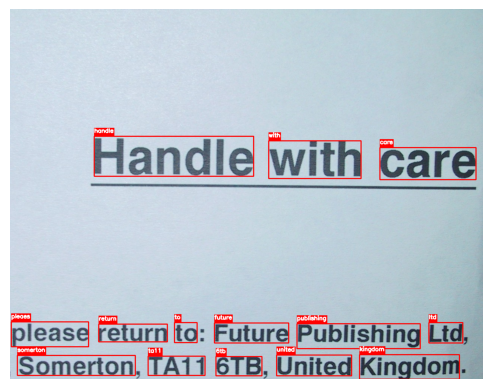

In [7]:
i = random.randint(0, len(image_paths))
plot_image_with_bbs(image_paths[i], bboxes[i], image_labels[i])

## Store all bounding boxes as a new dataset

In [8]:
def split_bounding_boxes(img_paths, img_labels, bboxes, save_dir):
    """Splits images into smaller crops based on bounding boxes and saves them."""
    os.makedirs(save_dir, exist_ok=True)

    count = 0
    labels = [] # List to store labels

    for img_path, img_label, bbs in zip(img_paths, img_labels, bboxes):
        img = Image.open(img_path) # Open the image

        for label, bb in zip(img_label, bbs):
            # Crop image using bounding box
            cropped_img = img.crop((bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]))

            # Skip if the cropped image is mostly black/white or too small
            if np.mean(cropped_img) < 35 or np.mean(cropped_img) > 220:
                continue
            if cropped_img.size[0] < 10 or cropped_img.size[1] < 10:
                continue

            # Save the cropped image
            filename = f"{count:06d}.jpg"
            cropped_img.save(os.path.join(save_dir, filename))

            # Record the label with the new image path
            new_img_path = os.path.join(save_dir, filename)
            labels.append(new_img_path + "\t" + label)

            count += 1
    
    print(f"Created {count} images") # Log the number of cropped images created

     # Save all labels to a text file
    with open(os.path.join(save_dir, "labels.txt"), "w", encoding="utf-8") as f:
        for label in labels:
            f.write(f"{label}\n")

In [9]:
save_dir = "/kaggle/working/datasets/orc_dataset"
split_bounding_boxes(image_paths, image_labels, bboxes, save_dir)

Created 1088 images


## Read Dataset

In [10]:
root_dir = save_dir

img_paths, labels = [], []

# Read labels from text file
with open(os.path.join(root_dir, "labels.txt"), "r", encoding="utf-8") as f:
    for label in f:
        labels.append(label.strip().split("\t")[1])
        img_paths.append(label.strip().split("\t")[0])

print(f"Total images: {len(img_paths)}")

Total images: 1088


## Prepare vocabulary

In [11]:
# Extract unique characters from labels
letters = [char.split(".")[0].lower() for char in labels] # Split by ".", take the first part, and convert to lowercase
letters = "".join(letters)  # Combine all characters into a single string
letters = sorted(list(set(list(letters)))) # Remove duplicates and sort characters

# Create a string of all unique characters
chars = "".join(letters)

# Add a "blank" character to the vocabulary
blank_char = "-"
chars += blank_char
vocab_size = len(chars) # Calculate vocabulary size

print(f"Vocab: {chars}")
print(f"Vocab size: {vocab_size}")

Vocab: 0123456789abcdefghijklmnopqrstuvwxyz-
Vocab size: 37


In [12]:
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [13]:
max_label_len = max([len(label) for label in labels])
max_label_len

14

In [14]:
def encode(label, char_to_idx, max_label_len):
    """Encodes a string label into a fixed-length tensor representation."""
    # Convert label characters to indices using char_to_idx
    encoded_labels = torch.tensor([char_to_idx[char] for char in label], dtype=torch.int32)

    # Length of the encoded label
    label_len = len(encoded_labels)
    lengths = torch.tensor(label_len, dtype=torch.int32)
    
    # Pad the encoded label to max_label_len with value 0
    padded_labels = F.pad(encoded_labels, (0, max_label_len - label_len), value=0)

    return padded_labels, lengths


def decode(encoded_sequences, idx_to_char, blank_char="-"):
    """Decodes encoded sequences back into strings."""
    decoded_sequences = [] 

    for seq in encoded_sequences:
        decoded_label = [] # Store decoded characters for a single sequence
        prev_char = None # Track the previous character to handle repeated characters

        for token in seq:
            if token != 0:  # Ignore padding (token = 0)
                char = idx_to_char[token.item()] # Map index to character
                # Append the character if it's not a blank or repeated
                if char != blank_char:
                    if char != prev_char or prev_char == blank_char:
                        decoded_label.append(char)
                prev_char = char # Update the previous character tracker
        
        # Join decoded characters into a single string
        decoded_sequences.append("".join(decoded_label))

    print(f"From {encoded_sequences} to {decoded_sequences}")
    return decoded_sequences

In [15]:
decode([torch.tensor([20, 30, 1, 20, 20, 1])], idx_to_char)

From [tensor([20, 30,  1, 20, 20,  1])] to ['isi']


['isi']

## Create data preprocessing function

In [16]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            transforms.Grayscale(num_output_channels=1),
            transforms.GaussianBlur(3),
            transforms.RandomAffine(degrees=1, shear=1),
            transforms.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=3),
            transforms.RandomRotation(degrees=2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ]
    )
}

## Train, Val, Test Split

In [17]:
seed = 0

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=0.1,
    random_state=seed,
    shuffle=True
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=0.1,
    random_state=seed,
    shuffle=True
)

len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(881, 881, 109, 109, 98, 98)

## Create Pytorch Dataset

In [18]:
class STRDataset(Dataset):
    def __init__(self, X, y, char_to_idx, max_label_len, label_encoder=None, transform=None):
        self.transform = transform
        self.img_paths = X
        self.labels = y
        self.char_to_idx = char_to_idx
        self.max_label_len = max_label_len
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        if self.label_encoder:
            encoded_label, label_len = self.label_encoder(label, self.char_to_idx, self.max_label_len)

        return img, encoded_label, label_len

## Create Dataloader

In [19]:
train_dataset = STRDataset(
    X_train, y_train,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["train"]
)

val_dataset = STRDataset(
    X_val, y_val,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["val"]
)

test_dataset = STRDataset(
    X_test, y_test,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["val"]
)

len(train_dataset), len(val_dataset), len(test_dataset)

(881, 109, 98)

In [20]:
train_batch_size = 64
test_batch_size = 64 * 2

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
)

len(train_loader), len(val_loader), len(test_loader)

(14, 1, 1)

From tensor([[31, 12, 35, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [16, 30, 30, 16, 35,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [20, 25, 31, 16, 23, 23, 20, 18, 16, 25, 14, 16,  0,  0],
        [31, 29, 12, 15, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [12, 29, 16, 25, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [30, 20, 18, 25, 26,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [29, 12, 20, 30, 16, 15,  0,  0,  0,  0,  0,  0,  0,  0],
        [12, 15, 12, 27, 31, 16, 29,  0,  0,  0,  0,  0,  0,  0],
        [24, 26, 29, 31, 18, 12, 18, 16, 30,  0,  0,  0,  0,  0],
        [14, 26, 25, 15, 20, 31, 20, 26, 25, 30,  0,  0,  0,  0],
        [19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [12, 32, 31, 19, 26, 29, 20, 30, 16, 15,  0,  0,  0,  0],
        [20, 25,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [15, 26,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [17, 12, 35,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
     

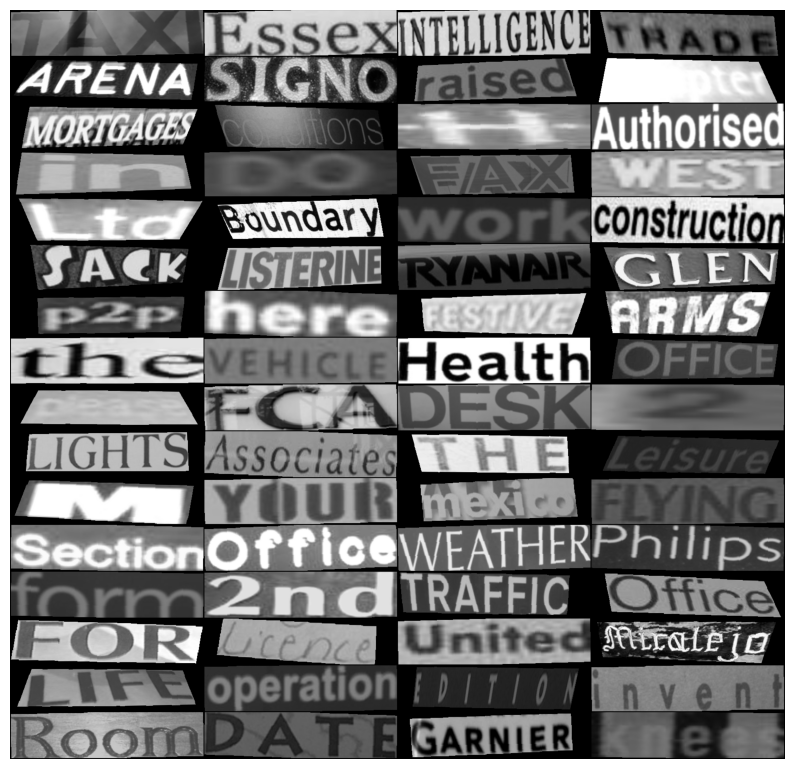

In [21]:
train_features, train_labels, train_lenghts = next(iter(train_loader))

def show_batch(imgs, labels):
    labels = decode(labels, idx_to_char)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True)
    plt.figure(figsize=(10, 20))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis("off")
    plt.show()


show_batch(train_features, train_labels)

## Create Model

In [22]:
class CRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers, dropout=0.2, unfreeze_layers=3):
        super(CRNN, self).__init__()
        
        # Backbone: ResNet152 with first layer adjusted for grayscale (1 channel)
        backbone = timm.create_model("resnet152", in_chans=1, pretrained=True)
        modules = list(backbone.children())[:-2] # Remove fully connected and pooling layers
        modules.append(nn.AdaptiveAvgPool2d((1, None))) # Adaptive pooling for variable width

        self.backbone = nn.Sequential(*modules)

        # Unfreeze last few layers of backbone for fine-tuning
        for param in self.backbone[-unfreeze_layers:].parameters():
            param.requires_grad = True

        # Map feature dimensions from ResNet output (2048) to GRU input size (512)
        self.mapSeq = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # GRU: Bi-directional RNN for sequential modeling
        self.gru = nn.GRU(
            512,
            hidden_size,
            n_layers,
            bidirectional=True,
            batch_first=True, # Input shape: (batch, sequence, features)
            dropout=dropout if n_layers > 1 else 0,
        )

        # Layer normalization to stabilize GRU outputs
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

        # Output layer: Map GRU output to vocabulary size with log-softmax
        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size),
            nn.LogSoftmax(dim=2)
        )

    @torch.autocast(device_type="cuda")
    def forward(self, x):
        # ResNet Backbone
        x = self.backbone(x) # Extract features from the image
        x = x.permute(0, 3, 1, 2) # Rearrange dimensions to (batch, sequence, features, height)
        x = x.view(x.size(0), x.size(1), -1) # Flatten feature map for GRU input
        
        # Map features to GRU input size
        x = self.mapSeq(x)
        
        # GRU for sequential modeling
        x, _ = self.gru(x)
        
        # Normalize GRU outputs
        x = self.layer_norm(x)
        
        # Map to vocabulary size and apply log-softmax
        x = self.out(x)
        
        # Rearrange dimensions for CTC Loss: (sequence_length, batch_size, vocab_size)
        x = x.permute(1, 0, 2)
        return x

In [23]:
hidden_size = 256
n_layers = 3
dropout_prob = 0.2
unfreeze_layers = 3
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers
).to(device)

model.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

In [24]:
model.eval()

dummy_tensor = torch.rand((64, 1, 100, 420)).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print("Output shape:", output.shape)

Output shape: torch.Size([14, 64, 37])


## Training

In [25]:
def fit(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        start = time.time()

        batch_train_losses = []

        model.train()
        for idx, (inputs, labels, labels_len) in enumerate(train_loader):
            inputs, labels, labels_len = inputs.to(device), labels.to(device), labels_len.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long
            ).to(device)

            loss = criterion(outputs, labels, logits_lens, labels_len)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f"Epoch {epoch + 1}: \t Train Loss: {train_loss:.4f}\t Val Loss: {val_loss:.4f}\t\t Time:{time.time() - start:.2f} seconds")

        scheduler.step()

    return train_losses, val_losses


def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []

    with torch.no_grad():
        for inputs, labels, labels_len in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels_len = labels_len.to(device)

            outputs = model(inputs)
            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long
            ).to(device)

            loss = criterion(outputs, labels, logits_lens, labels_len)
            losses.append(loss.item())

    loss = sum(losses) / len(losses)
    return loss

In [26]:
epochs = 100
lr = 5e-4
weight_decay = 1e-5
scheduler_step_size = epochs * 0.5

criterion = nn.CTCLoss(
    blank=char_to_idx[blank_char],
    zero_infinity=True,
    reduction="mean"
)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=0.1)

In [27]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

Epoch 1: 	 Train Loss: 4.4313	 Val Loss: 3.7245		 Time:15.04 seconds
Epoch 2: 	 Train Loss: 3.4779	 Val Loss: 3.4051		 Time:14.27 seconds
Epoch 3: 	 Train Loss: 3.2287	 Val Loss: 3.0738		 Time:14.31 seconds
Epoch 4: 	 Train Loss: 2.9307	 Val Loss: 3.1033		 Time:14.47 seconds
Epoch 5: 	 Train Loss: 2.6041	 Val Loss: 2.4134		 Time:14.33 seconds
Epoch 6: 	 Train Loss: 2.1048	 Val Loss: 2.4663		 Time:14.59 seconds
Epoch 7: 	 Train Loss: 1.6706	 Val Loss: 1.7312		 Time:14.70 seconds
Epoch 8: 	 Train Loss: 1.2329	 Val Loss: 1.2928		 Time:14.78 seconds
Epoch 9: 	 Train Loss: 0.9307	 Val Loss: 1.1714		 Time:15.15 seconds
Epoch 10: 	 Train Loss: 0.7566	 Val Loss: 1.0449		 Time:15.03 seconds
Epoch 11: 	 Train Loss: 0.6012	 Val Loss: 0.9413		 Time:15.38 seconds
Epoch 12: 	 Train Loss: 0.5238	 Val Loss: 0.9012		 Time:15.21 seconds
Epoch 13: 	 Train Loss: 0.4243	 Val Loss: 0.8574		 Time:15.58 seconds
Epoch 14: 	 Train Loss: 0.3853	 Val Loss: 0.9457		 Time:15.20 seconds
Epoch 15: 	 Train Loss: 0.342

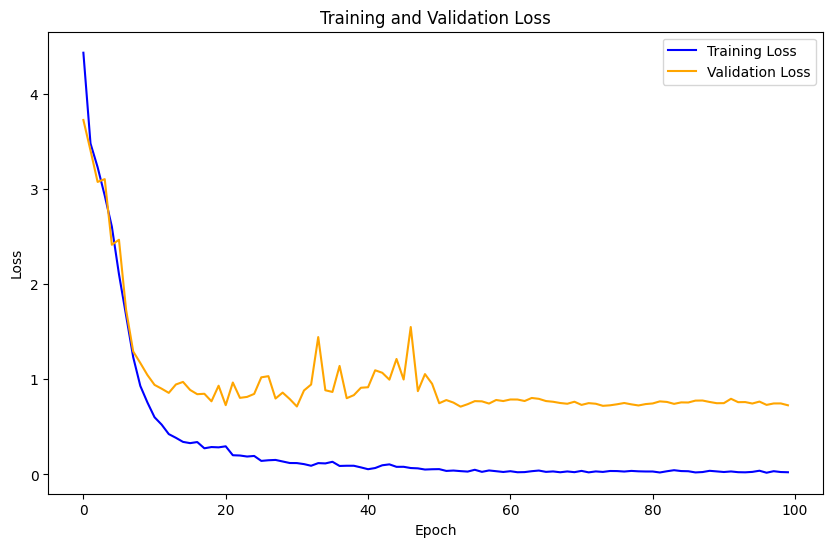

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(train_losses, label="Training Loss", color='blue')
ax.plot(val_losses, label="Validation Loss", color='orange')
ax.set_title("Training and Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.show()

## Evaluation

In [29]:
val_loss = evaluate(model, val_loader, criterion, device)
test_loss = evaluate(model, test_loader, criterion, device)

print("Evaluation on val/test dataset")
print(f"Val Loss: {val_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Evaluation on val/test dataset
Val Loss: 0.7271
Test Loss: 1.1448


## Make Predictions with PostProcessing

In [30]:
def predict(model, img):
    model.eval()
    with torch.no_grad():
        outputs = model(img)
        print(outputs)


def decode_label(encoded_sequences, idx_to_char, blank_char="-"):
    decoded_sequences = [] # To store decoded sequences

     # Iterate over each encoded sequence
    for seq in encoded_sequences:
        decoded_label = [] # Store decoded characters for this sequence
        
        # Process each token in the sequence
        for idx, token in enumerate(seq):
            if token != 0: # Skip padding
                char = idx_to_char[token.item()] # Get corresponding character
                if char != blank_char: # Skip blank character
                    decoded_label.append(char) # Add character to result
        
        # Join characters into a string
        decoded_sequences.append("".join(decoded_label))

    return decoded_sequences

From tensor([[ 1, 19,  1, 12, 29, 15, 15, 34, 34, 12, 12, 29, 16, 16]],
       device='cuda:0') to ['hardware']
From tensor([[ 1,  1, 16,  1,  1, 35, 35,  1, 20, 20,  1, 31, 31,  1]],
       device='cuda:0') to ['exit']
From tensor([[ 1, 31, 26,  1, 26, 31, 19, 27, 27, 12, 30, 31, 16, 16]],
       device='cuda:0') to ['toothpaste']
From tensor([[ 1, 23, 23, 16, 20, 20, 30, 32, 32, 29, 29, 16,  1,  1]],
       device='cuda:0') to ['leisure']
From tensor([[ 1,  1, 30,  1,  1, 14,  1, 29,  1, 26,  1, 23,  1, 23]],
       device='cuda:0') to ['scroll']
From tensor([[ 1, 14, 26, 23, 14, 14, 19, 16,  1, 30, 31, 16,  1, 29]],
       device='cuda:0') to ['colchester']
From tensor([[ 1,  1, 12, 12,  1,  1, 25,  1,  1, 15,  1,  1,  1,  1]],
       device='cuda:0') to ['and']
From tensor([[ 1, 17, 29, 16,  1, 16, 27, 19, 26, 26, 25, 16, 16,  1]],
       device='cuda:0') to ['freephone']
From tensor([[ 1,  1,  1, 14, 14,  1,  1, 12,  1,  1, 29,  1,  1,  1]],
       device='cuda:0') to ['car']
From

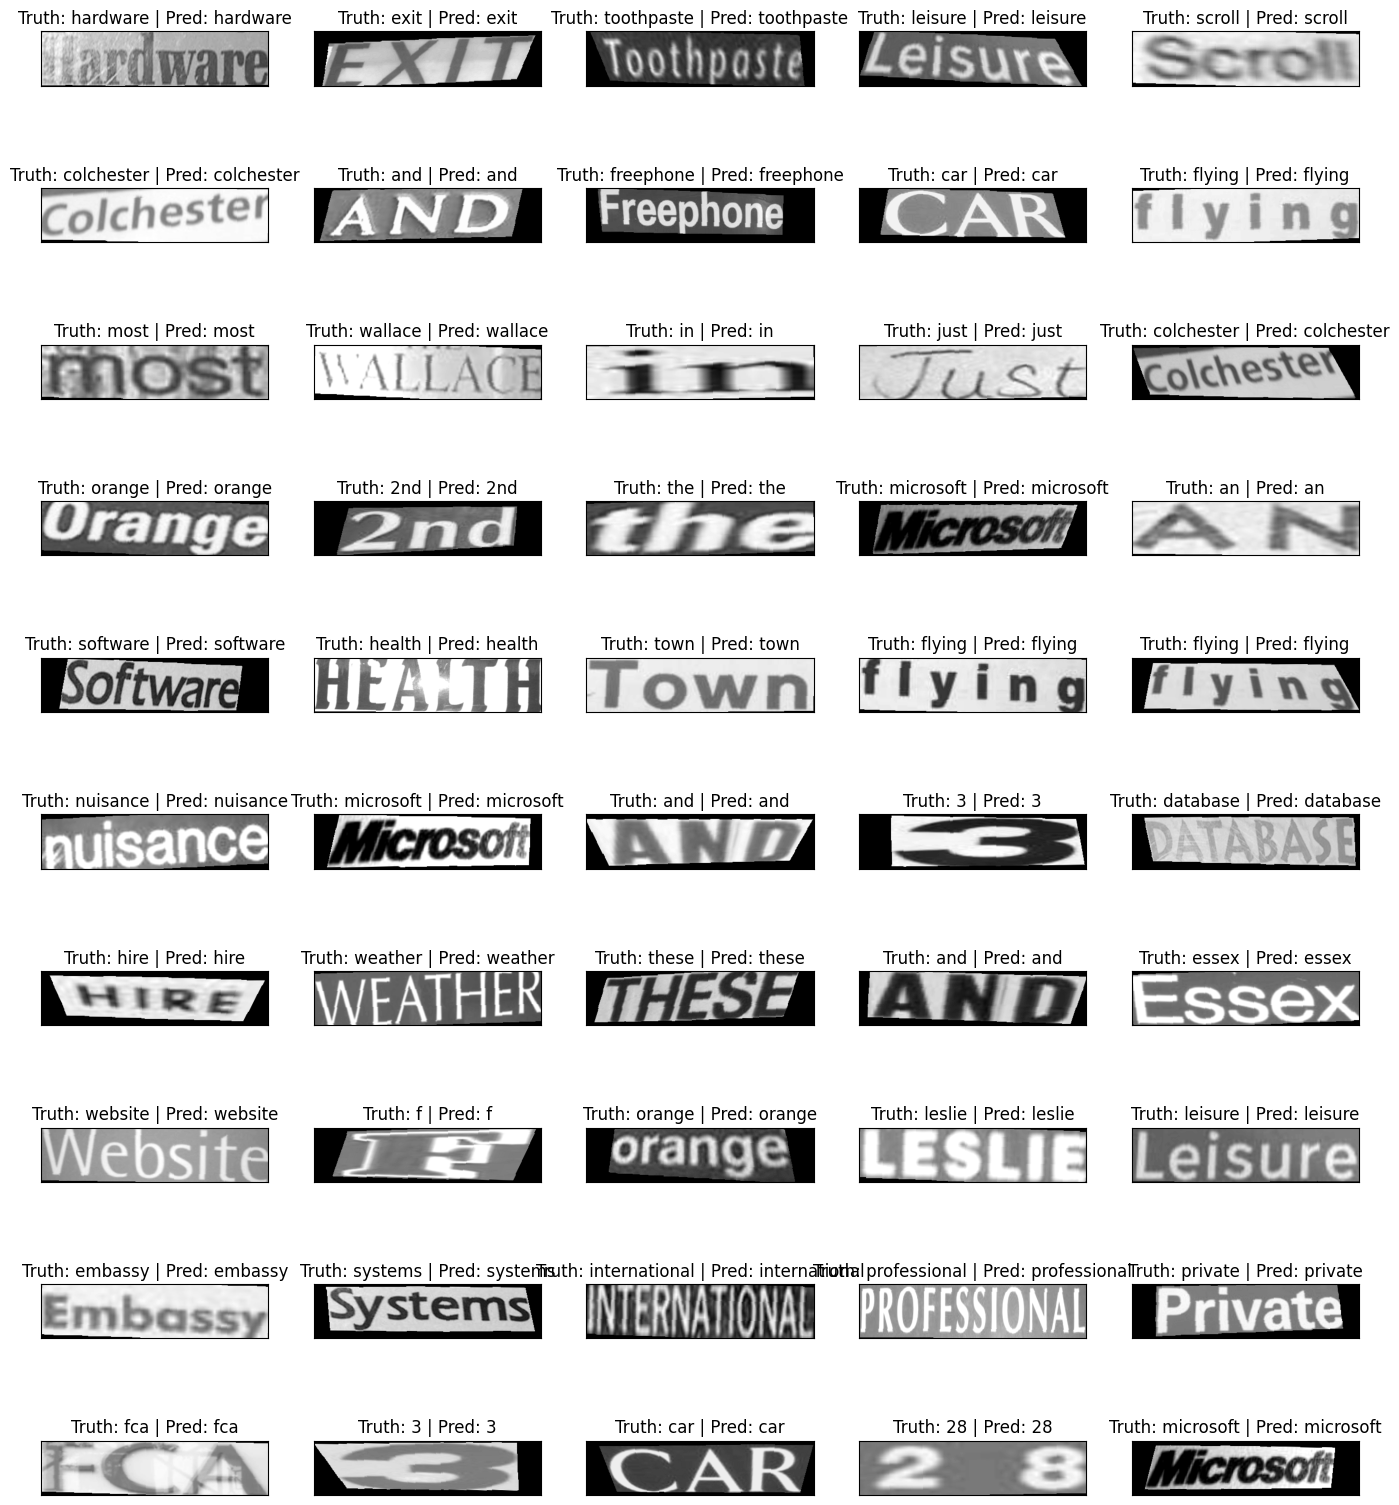

In [32]:
sample_result = [] # Store image, true label, and predicted label

for i in range(50):
    idx = np.random.randint(len(val_dataset)) # Random index from val set
    img, label, label_len = train_dataset[idx] # Get image and label
    img, label = img.to(device), label.to(device)
    
    label = decode_label([label], idx_to_char)[0] # Decode label
    logits = model(img.unsqueeze(0)) # Model prediction

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0] # Predicted text

    sample_result.append((img, label, pred_text)) # Store result

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i + 1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]  # Get image, true and predicted labels
    img = img.cpu()
    title = f"Truth: {label} | Pred: {pred_text}"

    ax.imshow(img.permute(1, 2, 0), cmap="gray")
    ax.set_title(title)

plt.show()

From tensor([[ 1,  1, 30, 30,  1, 20,  1, 31, 31,  1,  1, 16,  1,  1]],
       device='cuda:0') to ['site']
From tensor([[ 1, 34, 34,  1,  1,  1,  1, 12, 12,  1,  1, 36,  1,  1]],
       device='cuda:0') to ['way']
From tensor([[ 1,  1,  1,  1,  1,  1,  1,  1, 17, 17,  1,  1,  1,  1]],
       device='cuda:0') to ['f']
From tensor([[ 1, 23,  1, 20, 14, 14, 16,  1, 25, 25,  1, 14, 16,  1]],
       device='cuda:0') to ['licence']
From tensor([[ 1, 16,  1, 24,  1, 13,  1, 12, 12, 30,  1, 30, 36, 36]],
       device='cuda:0') to ['embassy']
From tensor([[ 1, 23, 23, 20, 20, 24,  1, 20, 31, 16, 16, 15, 15,  1]],
       device='cuda:0') to ['limited']
From tensor([[ 1,  1,  1,  1,  4,  1,  1,  1,  1, 12, 12,  1,  1,  1]],
       device='cuda:0') to ['2a']
From tensor([[ 1, 12, 30,  1, 30, 26,  1, 14, 20, 12, 31, 16, 30, 30]],
       device='cuda:0') to ['associates']
From tensor([[ 1, 33, 33,  1,  3,  3,  1,  1,  1,  1,  2,  1,  1,  1]],
       device='cuda:0') to ['v10']
From tensor([[ 1,  1

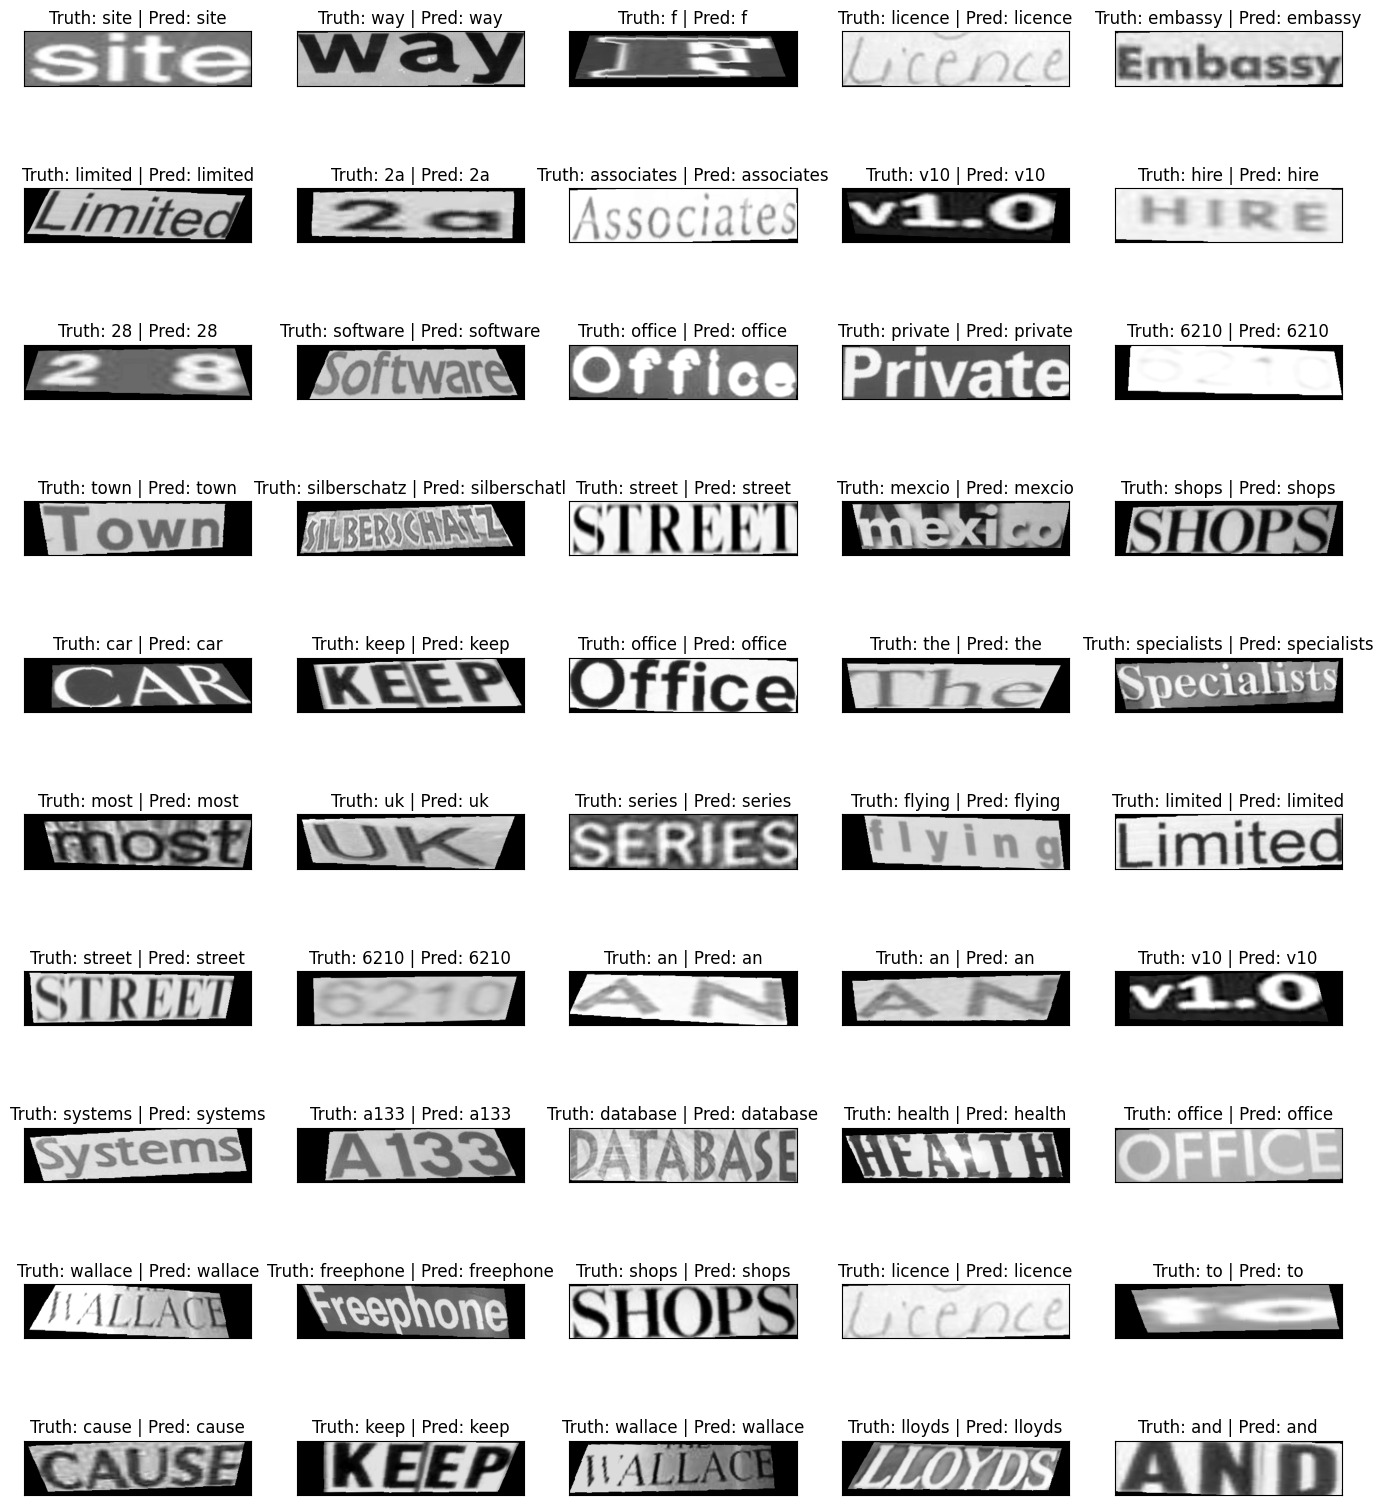

In [33]:
sample_result = [] # Store image, true label, and predicted label

for i in range(50):
    idx = np.random.randint(len(test_dataset)) # Random index from test set
    img, label, label_len = train_dataset[idx]
    img, label = img.to(device), label.to(device)
    
    label = decode_label([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i + 1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f"Truth: {label} | Pred: {pred_text}"

    ax.imshow(img.permute(1, 2, 0), cmap="gray")
    ax.set_title(title)

plt.show()

## Save model

In [35]:
save_model_path = "/kaggle/working/ocr_crnn.pt"
torch.save(model.state_dict(), save_model_path)